Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Medical Image Classification Tutorial with the MedNIST Dataset

In this tutorial, we introduce an end-to-end training and evaluation example based on the MedNIST dataset.

We'll go through the following steps:
* Create a dataset for training and testing
* Use MONAI transforms to pre-process data
* Use the DenseNet from MONAI for classification
* Train the model with a PyTorch program
* Evaluate on test dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb)

## Setup environment

In [24]:
!python -c "import monai"

/root/anaconda3/envs/env_seg/lib/python3.9/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

/root/anaconda3/envs/env_seg/lib/python3.9/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## Setup imports

In [27]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.3
Pytorch version: 2.4.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /<username>/anaconda3/envs/env_seg/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.0
scikit-image version: 0.22.0
scipy version: 1.13.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cu118
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.16.2
pynrrd version: 1.0.0
clearml version: 1.16.5rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
base_data_dir = '/data/result/zhongzhiqiang/MONAI/Data'
os.environ["MONAI_DATA_DIRECTORY"] = base_data_dir

directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/data/result/zhongzhiqiang/MONAI/Data


## Download dataset

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

If you use the MedNIST dataset, please acknowledge the source.

In [5]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics.  
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,  
which should be used as the labels to train our classification model.

In [15]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


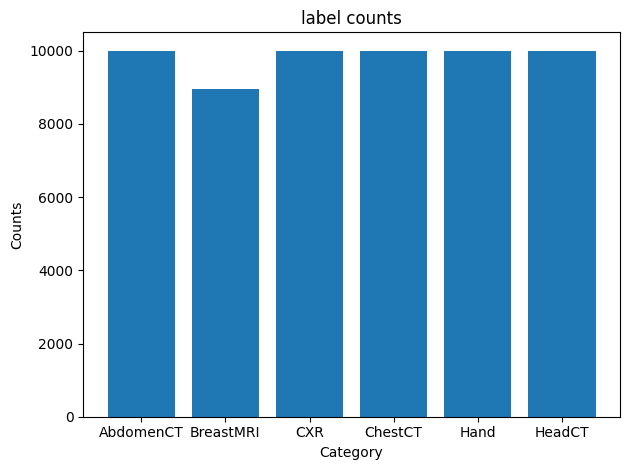

In [12]:
index = np.arange(len(class_names))
plt.bar(index, num_each)
plt.title('label counts')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.xticks(index, class_names)
plt.tight_layout()
plt.show()

## Randomly pick images from the dataset to visualize and check

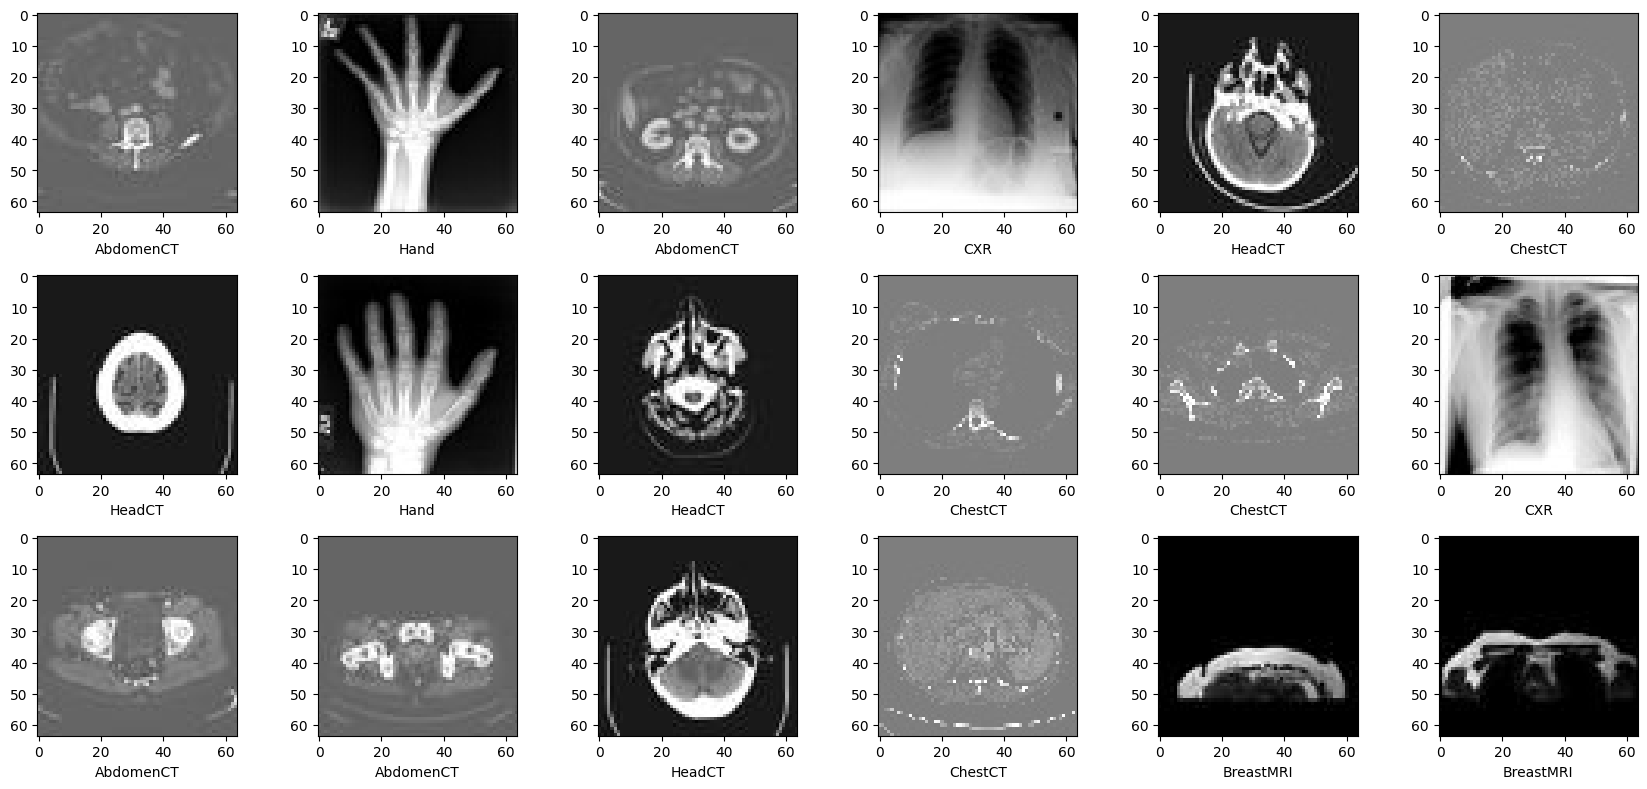

In [16]:
row, col = 3, 6
size = row * col
figsize = [l * 2 + (l - 1) for l in [row, col]][::-1]
plt.subplots(row, col, figsize=figsize)
for i, k in enumerate(np.random.randint(num_total, size=size)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(row, col, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists

Randomly select 10% of the dataset as validation and 10% as test.

In [17]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [18]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [19]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
And as this is just a get start tutorial, let's just train 4 epochs.  
If train 10 epochs, the model can achieve 100% accuracy on test dataset. 
1. Use DenseNet from MONAI and move to GPU device, this DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [21]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/4


1/157, train_loss: 1.7973
2/157, train_loss: 1.7520
3/157, train_loss: 1.7449
4/157, train_loss: 1.7140
5/157, train_loss: 1.6752
6/157, train_loss: 1.6564
7/157, train_loss: 1.6141
8/157, train_loss: 1.6093
9/157, train_loss: 1.5754
10/157, train_loss: 1.5611
11/157, train_loss: 1.5225
12/157, train_loss: 1.5004
13/157, train_loss: 1.4935
14/157, train_loss: 1.4570
15/157, train_loss: 1.4454
16/157, train_loss: 1.4166
17/157, train_loss: 1.4106
18/157, train_loss: 1.3745
19/157, train_loss: 1.3437
20/157, train_loss: 1.3382
21/157, train_loss: 1.3146
22/157, train_loss: 1.3649
23/157, train_loss: 1.2878
24/157, train_loss: 1.2392
25/157, train_loss: 1.2529
26/157, train_loss: 1.1913
27/157, train_loss: 1.2075
28/157, train_loss: 1.2057
29/157, train_loss: 1.2095
30/157, train_loss: 1.1338
31/157, train_loss: 1.1445
32/157, train_loss: 1.1351
33/157, train_loss: 1.1518
34/157, train_loss: 1.0837
35/157, train_loss: 1.0790
36/157, train_loss: 1.0808
37/157, train_loss: 1.0750
38/157, tr

## Plot the loss and metric

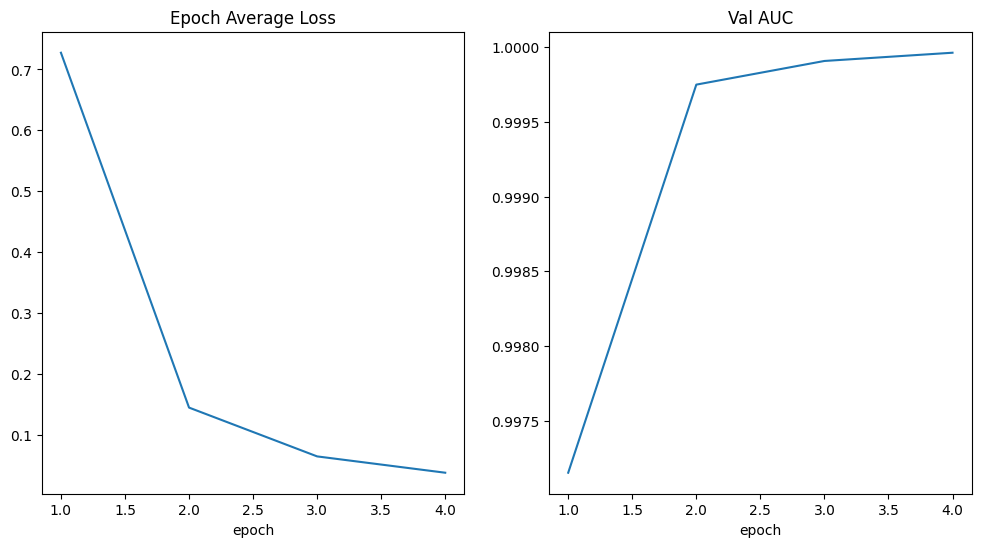

In [22]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

After training and validation, we already got the best model on validation test.  
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.  
We'll use these predictions to generate a classification report.

In [23]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [26]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9930    0.9920    0.9925       995
   BreastMRI     0.9966    0.9932    0.9949       880
         CXR     1.0000    0.9959    0.9980       982
     ChestCT     0.9912    1.0000    0.9956      1014
        Hand     0.9971    0.9914    0.9943      1048
      HeadCT     0.9929    0.9980    0.9954       976

    accuracy                         0.9951      5895
   macro avg     0.9951    0.9951    0.9951      5895
weighted avg     0.9951    0.9951    0.9951      5895



## Cleanup data directory

Remove directory if a temporary was used.

In [27]:
if directory is None:
    shutil.rmtree(root_dir)